<a href="https://colab.research.google.com/github/gladysadyaz/Hybrid-Method/blob/main/Hybrid_VARX_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Input Data**

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from google.colab import drive

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
file_path = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

Mounted at /content/drive
'Hybrid VARX_LSTM.ipynb'   Untitled0.ipynb  'wisman bali-kurs (1).xlsx'
'nyoba var-lstm.ipynb'	   VAR_YT.ipynb     'wisman bali-kurs.xlsx'
             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          0
2023-01-02  15572        12338          0
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


## **Praproses Data**

Normalisasi (Min-Max Scalling)

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[endog_vars] = scaler.fit_transform(df[endog_vars]) # Normalisasi hanya untuk variabel endogen
print(df_norm.head())


                Kurs  Wisman Bali  Hari Raya
Date                                        
2023-01-01  0.525739     0.440566          0
2023-01-02  0.514786     0.511547          0
2023-01-03  0.524644     0.502591          1
2023-01-04  0.538335     0.495750          1
2023-01-05  0.535597     0.558191          1


In [4]:
print("Min-Max Data Sebelum Normalisasi:")
print(df[endog_vars].min(), df[endog_vars].max())

print("\nMin-Max Data Setelah Normalisasi:")
print(df_norm[endog_vars].min(), df_norm[endog_vars].max())

Min-Max Data Sebelum Normalisasi:
Kurs           14632
Wisman Bali        0
dtype: int64 Kurs           16458
Wisman Bali    24119
dtype: int64

Min-Max Data Setelah Normalisasi:
Kurs           0.0
Wisman Bali    0.0
dtype: float64 Kurs           1.0
Wisman Bali    1.0
dtype: float64


## **Eksplorasi Data**

**Plot Data**

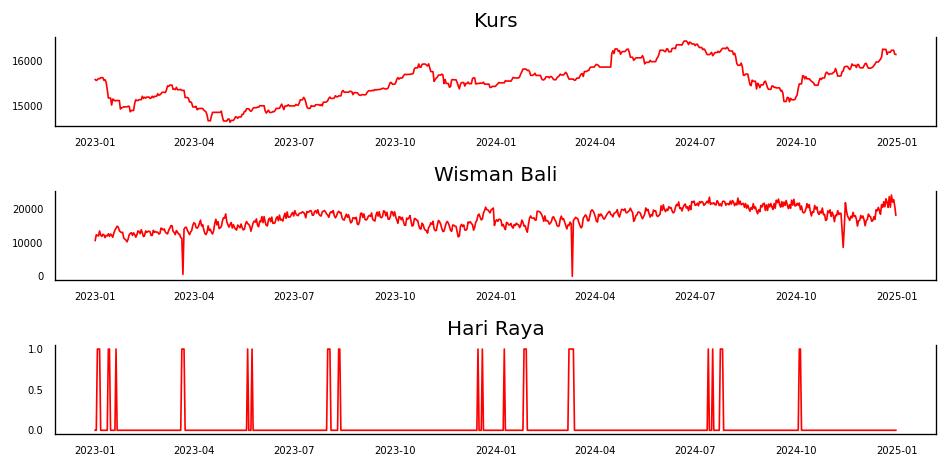

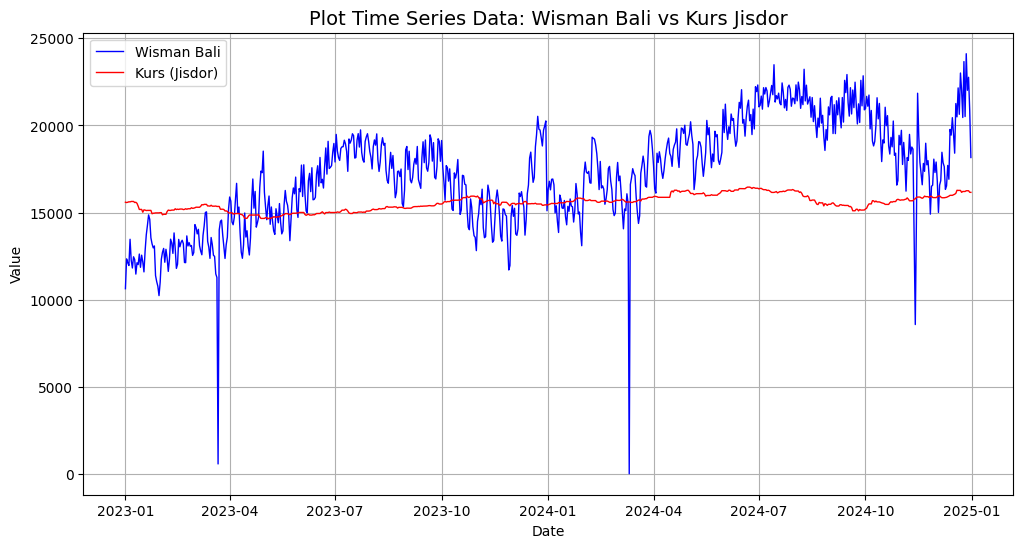

In [5]:
fig, axes = plt.subplots(nrows=3, dpi=120, figsize=(8, 4))

for i, ax in enumerate(axes):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Wisman Bali'], color='blue', linewidth=1, label='Wisman Bali')
plt.plot(df['Kurs'], color='red', linewidth=1, label='Kurs (Jisdor)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Time Series Data: Wisman Bali vs Kurs Jisdor', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


**Trend and Seasonal Plot**

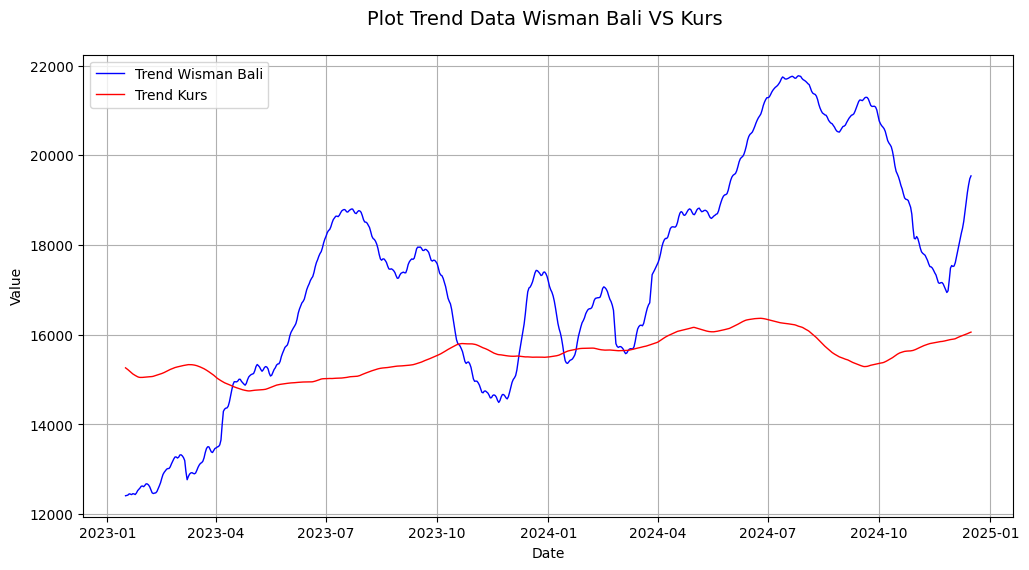

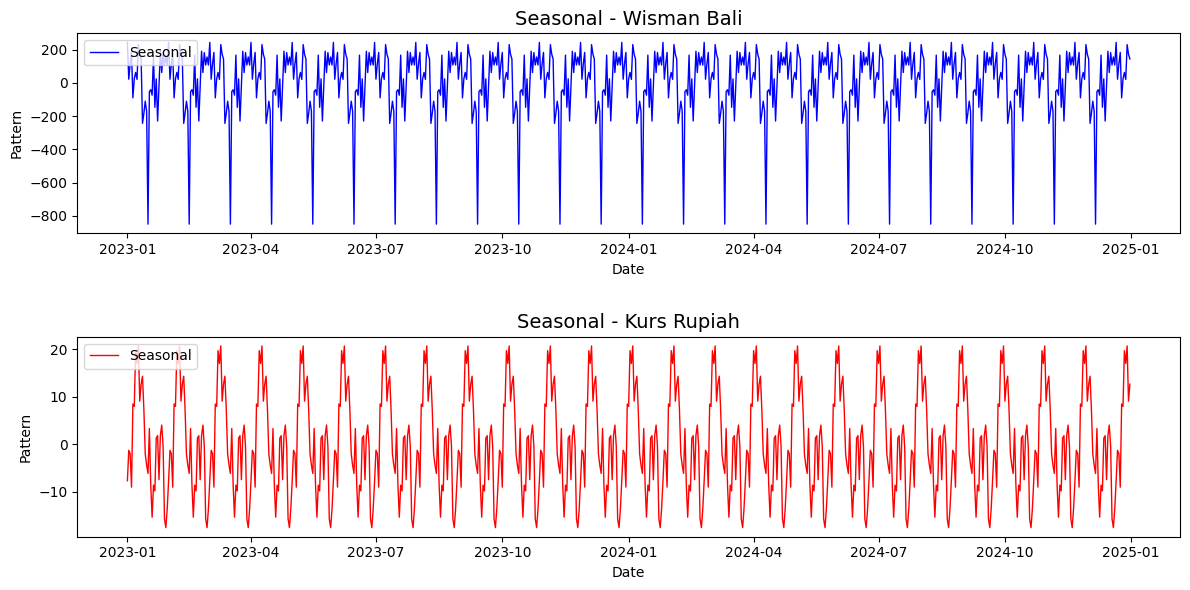

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
stl_wisman = seasonal_decompose(df['Wisman Bali'], model='additive', period=30)
stl_kurs = seasonal_decompose(df['Kurs'], model='additive', period=30)
#Plotting only Trend components
plt.figure(figsize=(12, 6))
plt.plot(stl_wisman.trend, label='Trend Wisman Bali', color='blue', linewidth=1)
plt.plot(stl_kurs.trend, label='Trend Kurs', color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Trend Data Wisman Bali VS Kurs \n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
# Plotting only Seasonal components
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stl_wisman.seasonal, label='Seasonal', color='blue', linewidth=1)
plt.title('Seasonal - Wisman Bali', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Pattern')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(stl_kurs.seasonal, label='Seasonal', color='red', linewidth=1)
plt.title('\nSeasonal - Kurs Rupiah', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Pattern')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Uji Korelasi**

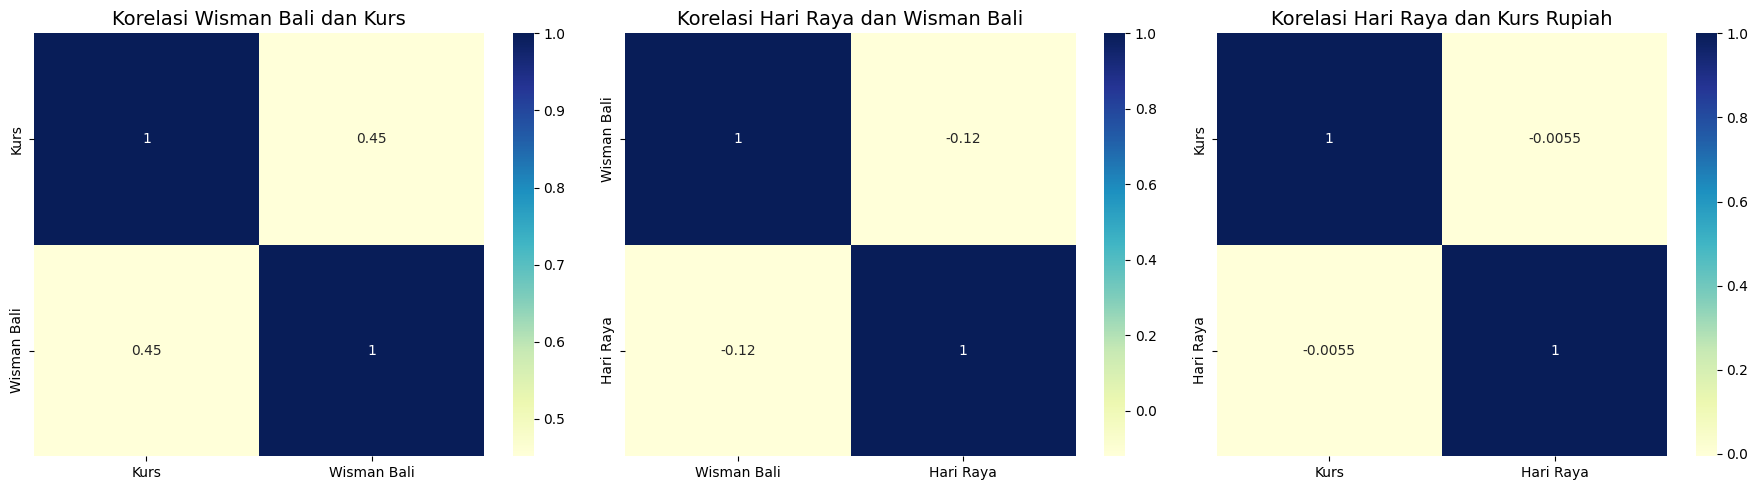

In [7]:
correlation_matrix1 = df[['Kurs', 'Wisman Bali']].corr()
correlation_matrix2 = df[['Wisman Bali', 'Hari Raya']].corr()
correlation_matrix3 = df[['Kurs', 'Hari Raya']].corr()
import seaborn as sns
#heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 baris, 3 kolom
correlation_matrices = [correlation_matrix1, correlation_matrix2, correlation_matrix3]
titles = ['Korelasi Wisman Bali dan Kurs', 'Korelasi Hari Raya dan Wisman Bali', 'Korelasi Hari Raya dan Kurs Rupiah']
for ax, corr_matrix, title in zip(axes, correlation_matrices, titles):
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", ax=ax)
    ax.set_title(title, fontsize=14)
plt.tight_layout()
plt.show()

Hubungan Kurs & Wisman Bali cukup kuat (0.45), sehingga Kurs bisa menjadi variabel penting dalam model VARX.
Hari Raya tampaknya tidak terlalu berpengaruh signifikan terhadap Kurs atau Wisman Bali berdasarkan korelasi langsung.

**Uji T-test**

In [8]:
from scipy.stats import ttest_ind
# Pisahkan data saat Hari Raya dan bukan Hari Raya
kurs_hari_raya = df[df['Hari Raya'] == 1]['Kurs']
kurs_non_hari_raya = df[df['Hari Raya'] == 0]['Kurs']

t_stat, p_value = ttest_ind(kurs_hari_raya, kurs_non_hari_raya)
print(f"T-test Kurs: p-value = {p_value}")
wisman_hari_raya = df[df['Hari Raya'] == 1]['Wisman Bali']
wisman_non_hari_raya = df[df['Hari Raya'] == 0]['Wisman Bali']

t_stat, p_value = ttest_ind(wisman_hari_raya, wisman_non_hari_raya)
print(f"T-test Wisman: p-value = {p_value}")

T-test Kurs: p-value = 0.8820096498613704
T-test Wisman: p-value = 0.0010574942441761584


Jika p-value < 0.05, berarti ada perbedaan signifikan pada Kurs atau Wisman saat Hari Raya. Wisman memiliki perbedaan signifikan

**Uji Kausalitas (Granger Causality)**

In [25]:
def granger_test(df, dep_var, indep_var, maxlag=9):
    print(f"\n Uji Granger Causality: Apakah {indep_var} memengaruhi {dep_var}?")
    result = grangercausalitytests(df[[dep_var, indep_var]], maxlag=maxlag, verbose=False)

    for lag in range(1, maxlag + 1):
        p_value = result[lag][0]['ssr_ftest'][1]  # Ambil p-value dari SSR F-test

        if p_value < 0.05:
            print(f"v Lag {lag}: p-value = {p_value:.4f} (< 0.05), {indep_var} **menyebabkan** {dep_var}.")
        else:
            print(f"x Lag {lag}: p-value = {p_value:.4f} (>= 0.05), tidak ada bukti signifikan bahwa {indep_var} menyebabkan {dep_var}.")

granger_test(df, 'Wisman Bali', 'Kurs', maxlag=9)
granger_test(df, 'Kurs', 'Wisman Bali', maxlag=9)
granger_test(df, 'Kurs', 'Hari Raya', maxlag=9)
granger_test(df, 'Wisman Bali', 'Hari Raya', maxlag=9)


 Uji Granger Causality: Apakah Kurs memengaruhi Wisman Bali?
v Lag 1: p-value = 0.0001 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 2: p-value = 0.0072 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 3: p-value = 0.0407 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 4: p-value = 0.0465 (< 0.05), Kurs **menyebabkan** Wisman Bali.
x Lag 5: p-value = 0.2255 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 6: p-value = 0.2879 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 7: p-value = 0.4949 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 8: p-value = 0.1905 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 9: p-value = 0.2163 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.

 Uji Granger Causality: Apakah Wisman Bali memengaruhi Kurs?
x Lag 1: p-value = 0.4462 (>= 0.05), tidak ada bukti signifikan bahwa Wisman Bali menyebabkan Ku

Jika p-value < 0.05, berarti Hari Raya memiliki efek signifikan terhadap Kurs atau Wisman dalam lag tertentu.

In [10]:
from statsmodels.tsa.stattools import coint
coint_result = coint(df['Kurs'], df['Wisman Bali'])
print("Engle-Granger Cointegration Test")
print(f"Test Statistic: {coint_result[0]}")
print(f"p-value: {coint_result[1]}")
if coint_result[1] < 0.05:
    print("Seri ini berkointegrasi (p < 0.05).")
else:
    print("Seri ini tidak berkointegrasi.")

Engle-Granger Cointegration Test
Test Statistic: -2.0719910395586703
p-value: 0.49101303874948604
Seri ini tidak berkointegrasi.


Augmented Dickey-Fuller Test

Wisman Bali
   Test Statistic: -1.6838
   p-value: 0.4395
   Critical Values: {'1%': np.float64(-3.439593802573824), '5%': np.float64(-2.865619356068967), '10%': np.float64(-2.568942332870462)}
   Tidak Stasioner

Kurs
   Test Statistic: -1.5254
   p-value: 0.5209
   Critical Values: {'1%': np.float64(-3.4394522667904153), '5%': np.float64(-2.8655569894909805), '10%': np.float64(-2.568909106765338)}
   Tidak Stasioner


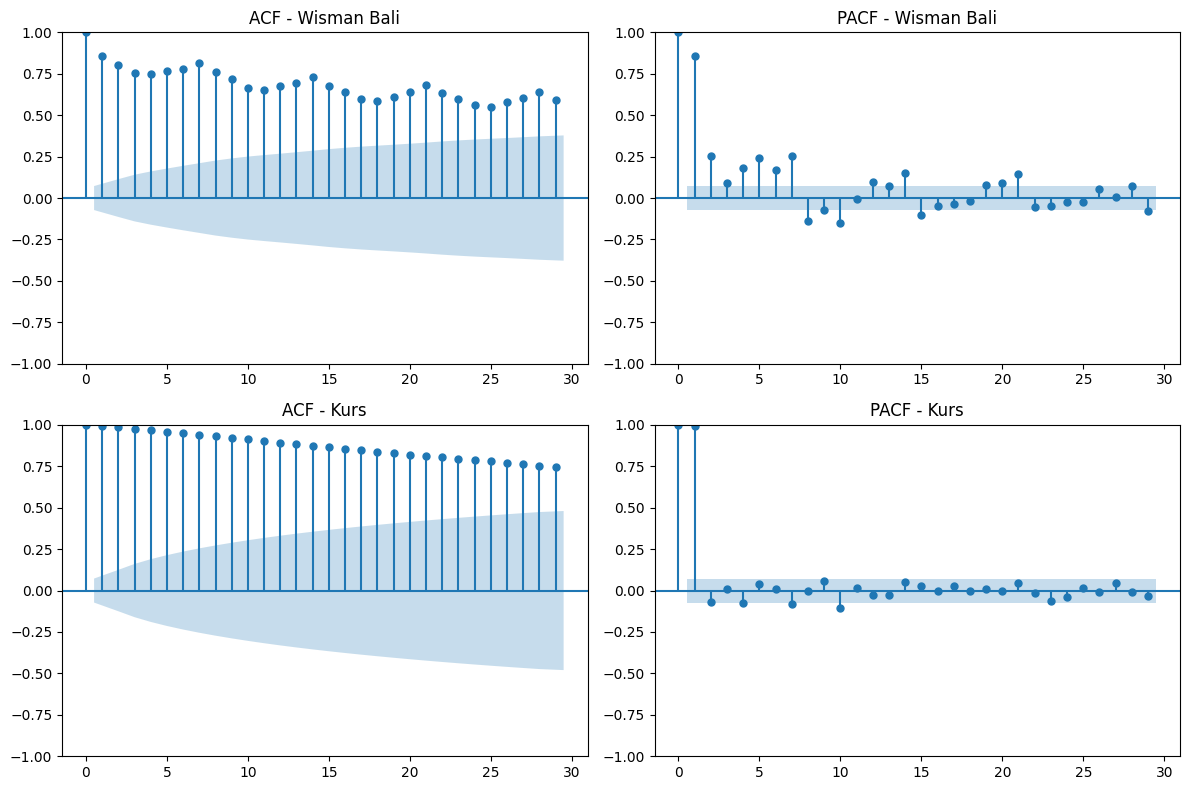

In [11]:
def adf_test(series, signif=0.05):
    stat, p_value, _, _, critical_values, _ = adfuller(series, autolag='AIC')
    return p_value <= signif, {'Test Statistic': stat, 'p-value': p_value, 'Critical Values': critical_values}

stationary_wisman, adf_wisman = adf_test(df_norm['Wisman Bali'])
stationary_kurs, adf_kurs = adf_test(df_norm['Kurs'])
print("Augmented Dickey-Fuller Test")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman, adf_kurs], [stationary_wisman, stationary_kurs]):
    print(f"\n{name}")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_norm['Wisman Bali'], ax=axes[0, 0], title="ACF - Wisman Bali")
plot_pacf(df_norm['Wisman Bali'], ax=axes[0, 1], title="PACF - Wisman Bali")
plot_acf(df_norm['Kurs'], ax=axes[1, 0], title="ACF - Kurs")
plot_pacf(df_norm['Kurs'], ax=axes[1, 1], title="PACF - Kurs")

plt.tight_layout()
plt.show()


ADF Test Setelah Differencing

Wisman Bali (Setelah Differencing)
   Test Statistic: -7.9175
   p-value: 0.0000
   Critical Values: {'1%': np.float64(-3.439606888036868), '5%': np.float64(-2.865625121924057), '10%': np.float64(-2.5689454046801052)}
   Stasioner

Kurs (Setelah Differencing)
   Test Statistic: -8.0315
   p-value: 0.0000
   Critical Values: {'1%': np.float64(-3.4394522667904153), '5%': np.float64(-2.8655569894909805), '10%': np.float64(-2.568909106765338)}
   Stasioner


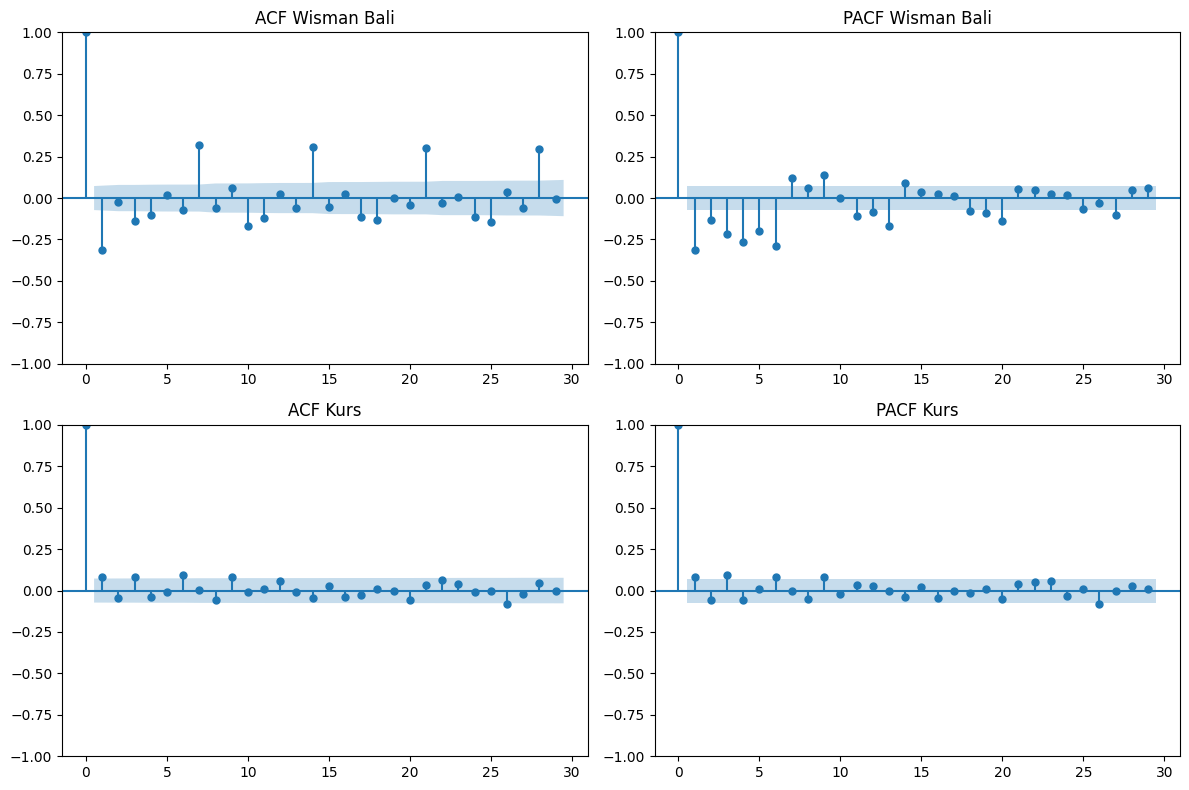

In [12]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

df_norm_diff = df_norm.copy()
df_norm_diff[endog_vars] = df_norm[endog_vars].diff().dropna() # Differencing hanya untuk variabel endogen
df_norm_diff[exog_vars] = df_norm[exog_vars] # Eksogen tetap pakai data aslinya
df_norm_diff = df_norm_diff.dropna()

stationary_wisman_diff, adf_wisman_diff = adf_test(df_norm_diff['Wisman Bali'])
stationary_kurs_diff, adf_kurs_diff = adf_test(df_norm_diff['Kurs'])
print("ADF Test Setelah Differencing")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman_diff, adf_kurs_diff], [stationary_wisman_diff, stationary_kurs_diff]):
    print(f"\n{name} (Setelah Differencing)")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_norm_diff['Wisman Bali'], ax=axes[0, 0], title="ACF Wisman Bali")
plot_pacf(df_norm_diff['Wisman Bali'], ax=axes[0, 1], title="PACF Wisman Bali")
plot_acf(df_norm_diff['Kurs'], ax=axes[1, 0], title="ACF Kurs")
plot_pacf(df_norm_diff['Kurs'], ax=axes[1, 1], title="PACF Kurs")

plt.tight_layout()
plt.show()


## **Modeling**

### **VARX**

####Plot Splitting Window Cross Validation

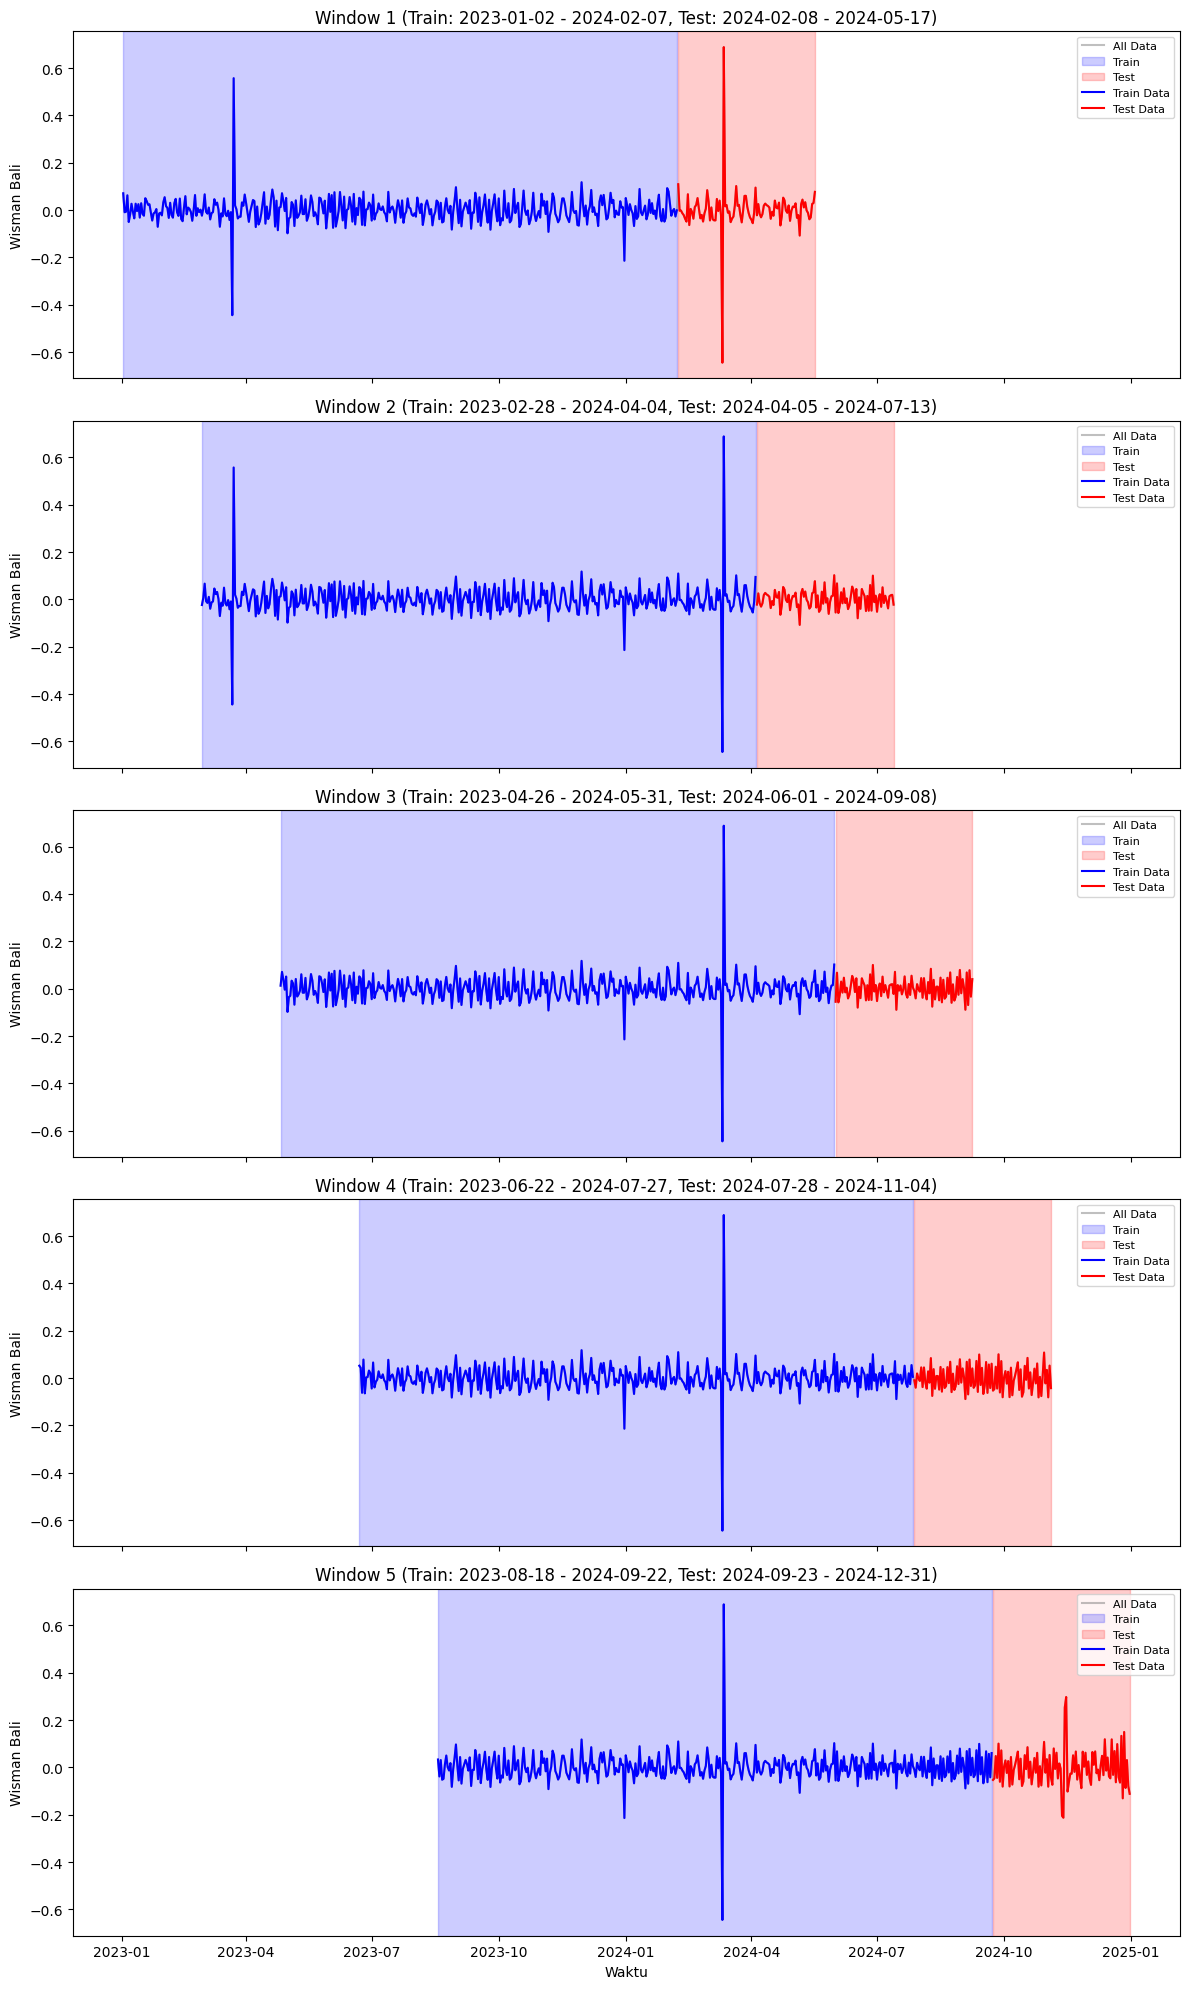

In [26]:
import matplotlib.pyplot as plt
window_size = 502     # Total data per window
n_test = 100          # Ukuran test set per window
n_train = window_size - n_test  # Ukuran train set per window
shift = 57             # Geser window sebanyak 57 data tiap iterasi
n_total = len(df_norm_diff)

# Buat figure dengan 5 subplot (satu per window)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)

for i in range(5):
    start = i * shift
    end = start + window_size

    # Pastikan window tidak melebihi total data
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena indeks window ({end}) melebihi total data ({n_total}).")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    ax = axes[i]

    # Plot data 'Kurs' sebagai garis
    ax.plot(window_data.index, window_data['Wisman Bali'], color='gray', alpha=0.5, label='All Data')

    # Highlight area train dan test dengan shading
    ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2, label='Train')
    ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2, label='Test')

    # Tampilkan garis tepi untuk train dan test
    ax.plot(train.index, train['Wisman Bali'], color='blue', label='Train Data')
    ax.plot(test.index, test['Wisman Bali'], color='red', label='Test Data')

    ax.set_title(f"Window {i+1} (Train: {train.index[0].date()} - {train.index[-1].date()}, Test: {test.index[0].date()} - {test.index[-1].date()})")
    ax.set_ylabel("Wisman Bali")
    ax.legend(loc='upper right', fontsize=8)

plt.xlabel("Waktu")
plt.tight_layout()
plt.show()

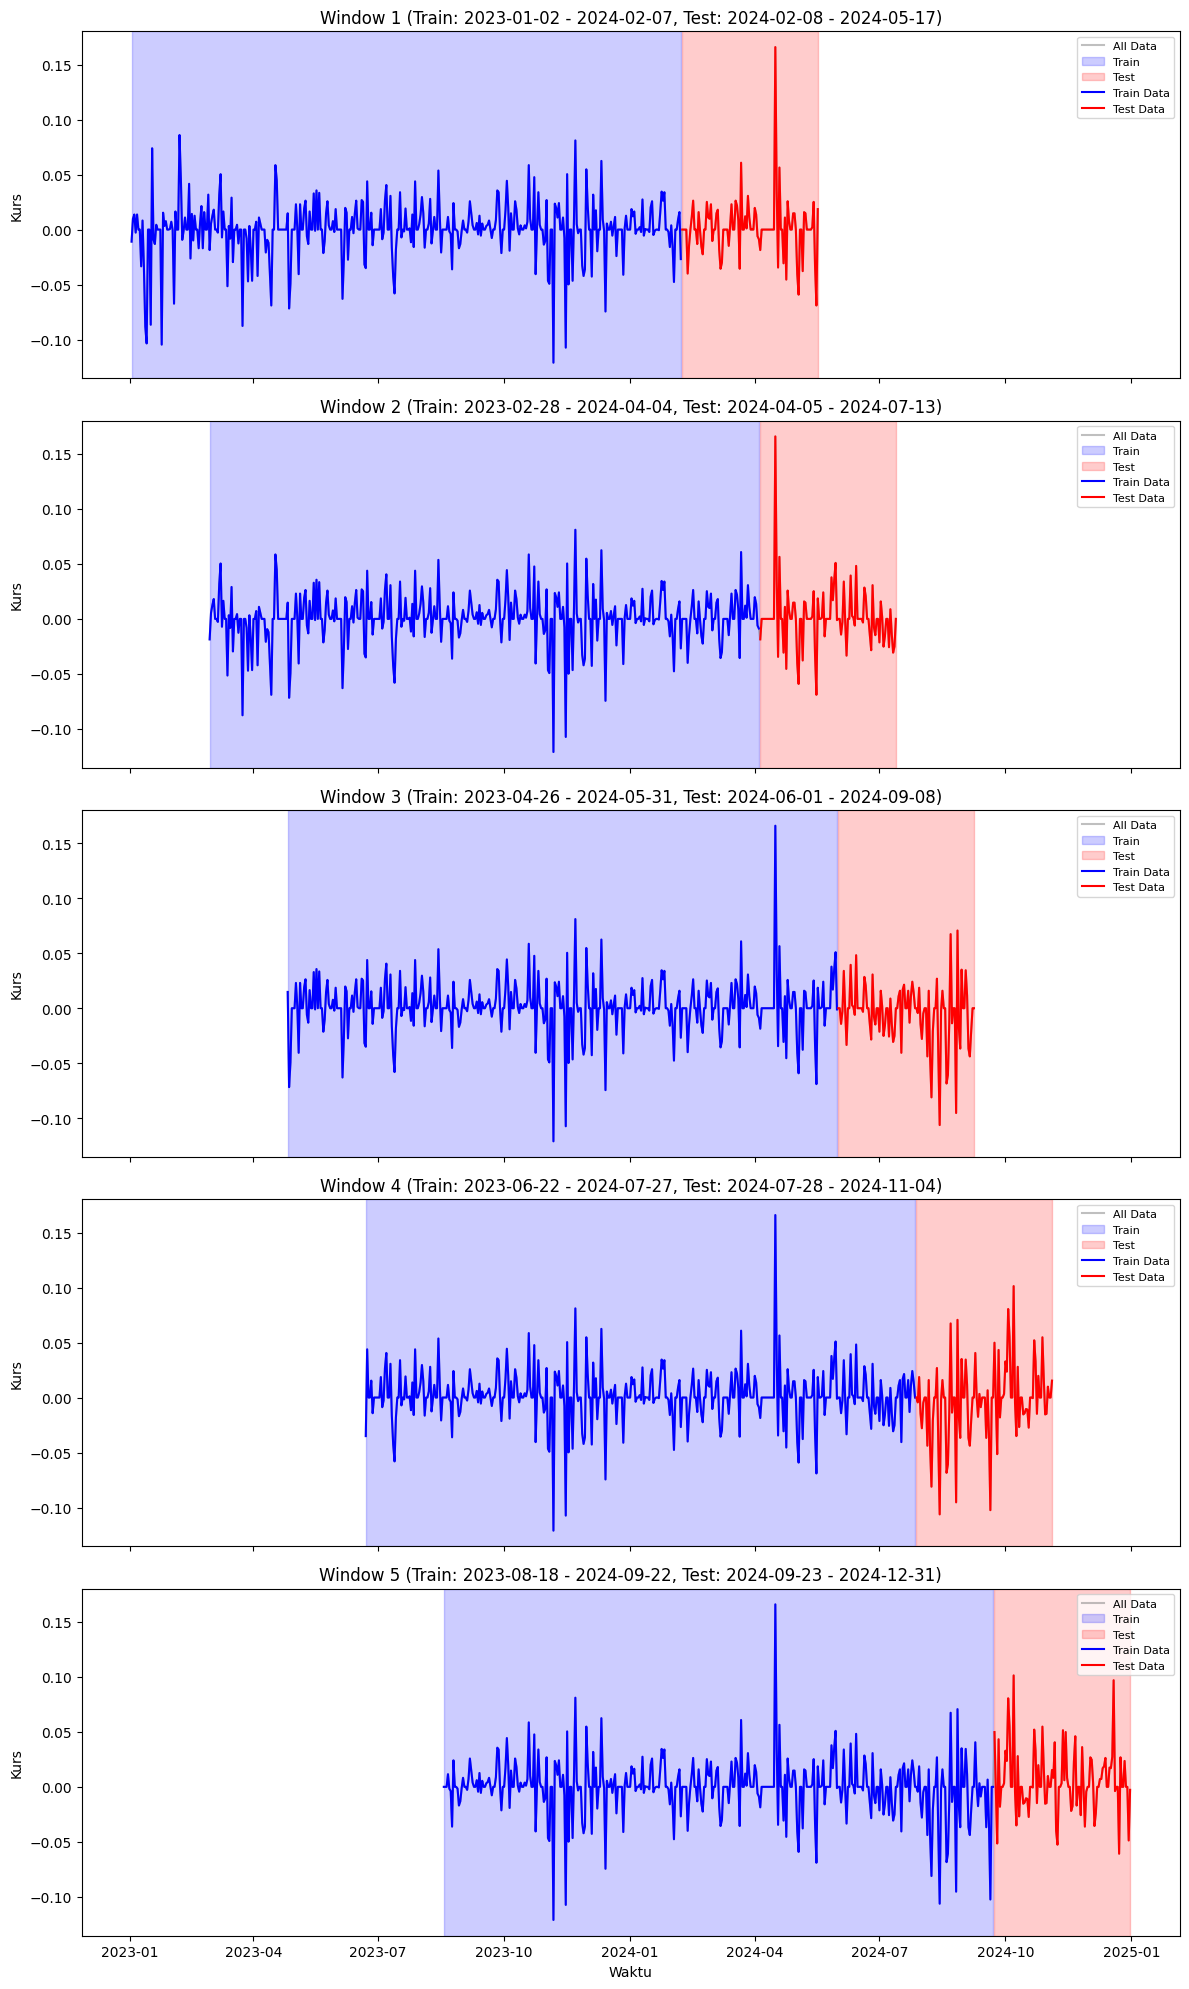

In [27]:
import matplotlib.pyplot as plt
window_size = 502     # Total data per window
n_test = 100          # Ukuran test set per window
n_train = window_size - n_test  # Ukuran train set per window
shift = 57             # Geser window sebanyak 57 data tiap iterasi
n_total = len(df_norm_diff)

# Buat figure dengan 5 subplot (satu per window)
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)

for i in range(5):
    start = i * shift
    end = start + window_size

    # Pastikan window tidak melebihi total data
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena indeks window ({end}) melebihi total data ({n_total}).")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    ax = axes[i]

    # Plot data 'Kurs' sebagai garis
    ax.plot(window_data.index, window_data['Kurs'], color='gray', alpha=0.5, label='All Data')

    # Highlight area train dan test dengan shading
    ax.axvspan(train.index[0], train.index[-1], color='blue', alpha=0.2, label='Train')
    ax.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2, label='Test')

    # Tampilkan garis tepi untuk train dan test
    ax.plot(train.index, train['Kurs'], color='blue', label='Train Data')
    ax.plot(test.index, test['Kurs'], color='red', label='Test Data')

    ax.set_title(f"Window {i+1} (Train: {train.index[0].date()} - {train.index[-1].date()}, Test: {test.index[0].date()} - {test.index[-1].date()})")
    ax.set_ylabel("Kurs")
    ax.legend(loc='upper right', fontsize=8)

plt.xlabel("Waktu")
plt.tight_layout()
plt.show()

####**Sliding Cross Validation Lag Optimal**

In [20]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter untuk sliding window baru
window_size = 502            # Total data per window
n_test = 100                 # Ukuran test per window
n_train = window_size - n_test  # Ukuran train per window
shift = 57                   # Geser window sebanyak 57 data tiap iterasi
n_total = len(df_norm_diff)       # Total data

mape_kurs_scores = []
mape_wisman_scores = []

# Loop untuk membuat 5 window
for i in range(5):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Looping untuk mencari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih model dengan AIC terendah
    best_idx = df_lag['AIC'].idxmin()
    best_order = df_lag.loc[best_idx, 'Lag']

    # Fit ulang model dengan lag terbaik
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(int(best_order), 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())

    # Forecast dengan data normalisasi
    forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

    # Denormalisasi hasil forecast
    forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                   columns=endog_vars, index=test.index)
    # Denormalisasi test data
    test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                               columns=endog_vars, index=test.index)

    # Hitung MAPE untuk masing-masing variabel
    mape_kurs = mean_absolute_percentage_error(test_denorm['Kurs'], forecast_denorm['Kurs'])
    mape_wisman = mean_absolute_percentage_error(test_denorm['Wisman Bali'], forecast_denorm['Wisman Bali'])

    mape_kurs_scores.append(mape_kurs)
    mape_wisman_scores.append(mape_wisman)

    print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

# Rata-rata MAPE dari semua window
final_mape_kurs = np.mean(mape_kurs_scores)
final_mape_wisman = np.mean(mape_wisman_scores)
print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")



Window 1 - Evaluasi Lag:
    Lag          AIC          BIC
0     1 -3023.392004 -2979.431031
1     2 -3022.614659 -2962.667877
2     3 -3034.721726 -2958.789136
3     4 -3049.991504 -2958.073106
4     5 -3077.870038 -2969.965831
5     6 -3107.327173 -2983.437158
6     7 -3125.529864 -2985.654041
7     8 -3127.042757 -2971.181125
8     9 -3129.853688 -2958.006248
9    10 -3126.125667 -2938.292419
10   11 -3131.537677 -2927.718621
11   12 -3131.751272 -2911.946407
12   13 -3138.215992 -2902.425319
13   14 -3142.450294 -2890.673813
14   15 -3136.020737 -2868.258447

Window 1 | Best Lag: 14 | AIC: -3142.45
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  402
Model:                            VARX(14)   Log Likelihood                1634.225
                               + intercept   AIC                          -3142.450
Date:                     Fri, 21 Mar 2025   BIC     

####**Sliding Cross Validation (Lag 9)**

In [21]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter untuk sliding window
window_size = 502  # Total data per window
n_test = 100        # Ukuran test per window
n_train = window_size - n_test  # Ukuran train per window
shift = 57          # Geser window sebanyak 57 data tiap iterasi
n_total = len(df_norm_diff)  # Total data

mape_kurs_scores = []
mape_wisman_scores = []

# Loop untuk membuat 5 window
for i in range(5):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break
    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Fit model dengan lag 9
    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(9, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 9 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast dengan data normalisasi
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi hasil forecast
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)

        # Denormalisasi test data
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Hitung MAPE untuk masing-masing variabel
        mape_kurs = mean_absolute_percentage_error(test_denorm['Kurs'], forecast_denorm['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_denorm['Wisman Bali'], forecast_denorm['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE dari semua window
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")



Window 1 | Lag: 9 | AIC: -3129.85
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  402
Model:                             VARX(9)   Log Likelihood                1607.927
                               + intercept   AIC                          -3129.854
Date:                     Fri, 21 Mar 2025   BIC                          -2958.006
Time:                             01:05:45   HQIC                         -3061.813
Sample:                         01-02-2023                                         
                              - 02-07-2024                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.02, 0.04   Jarque-Bera (JB):     312.57, 16260.16
Prob(Q):                        0.89, 0.83   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.85, 0.3

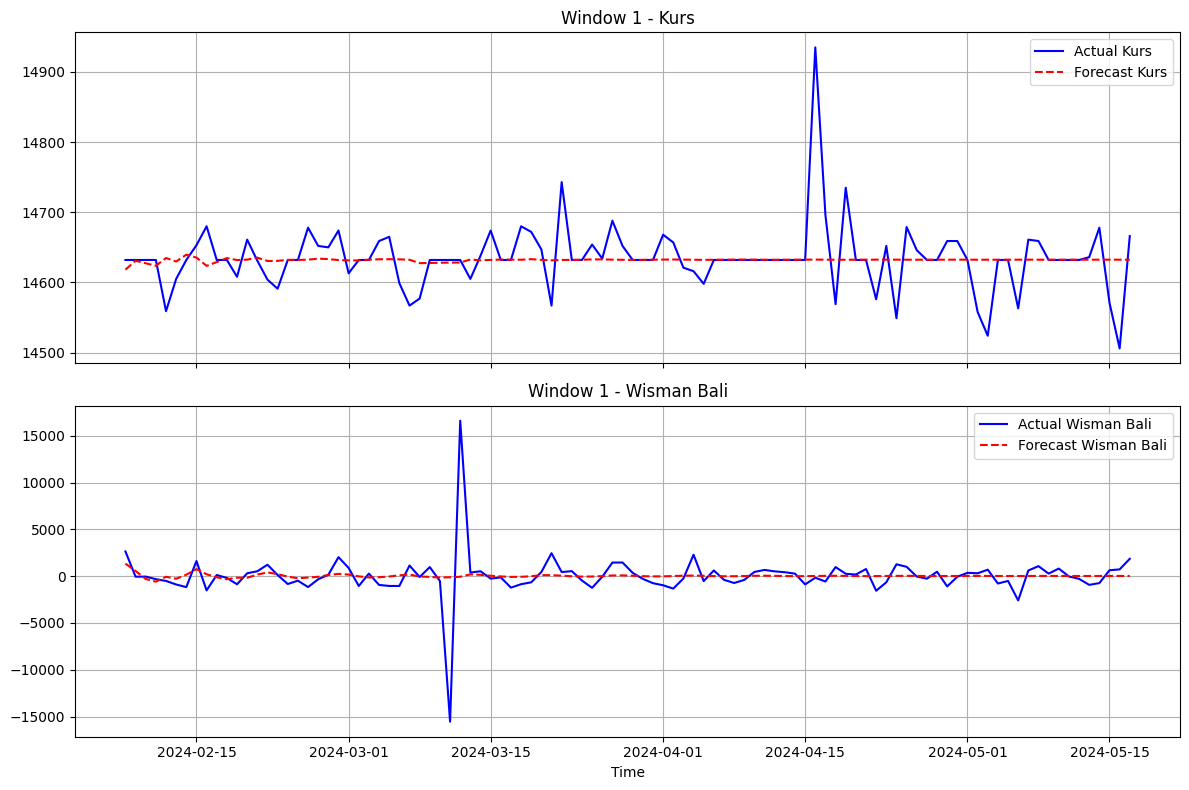

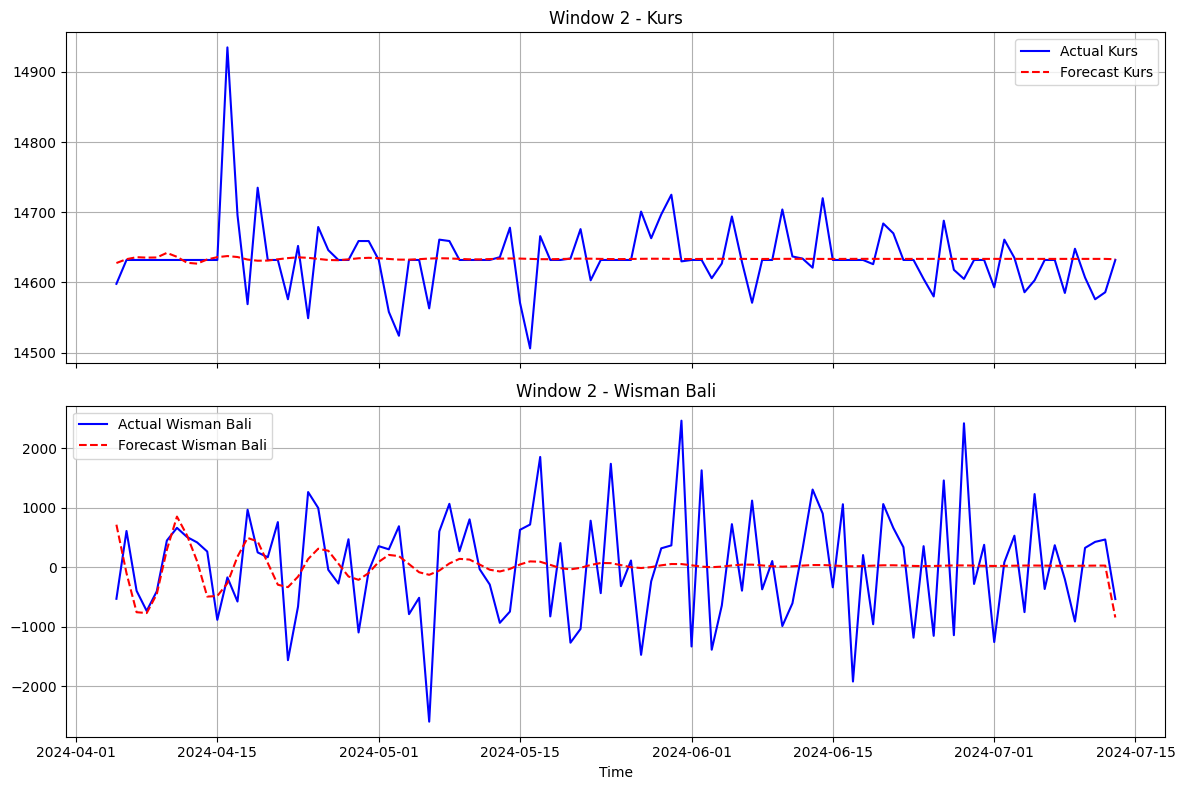

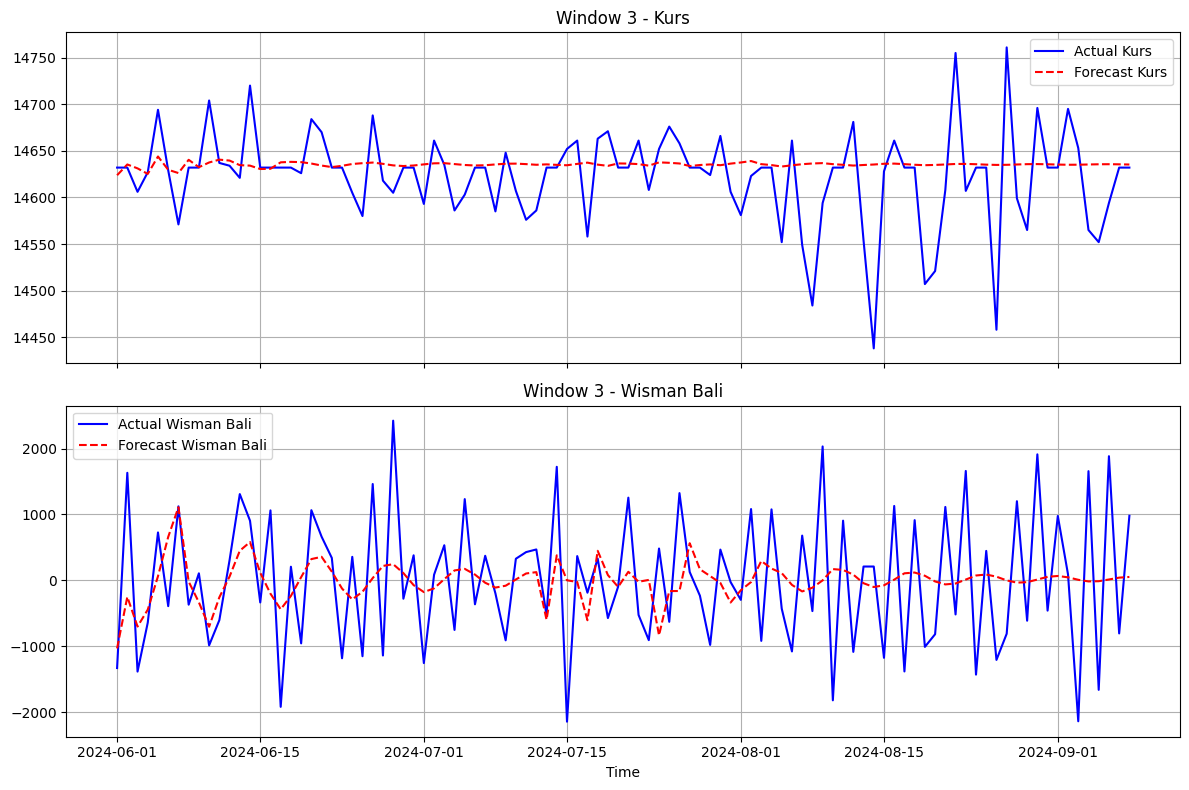

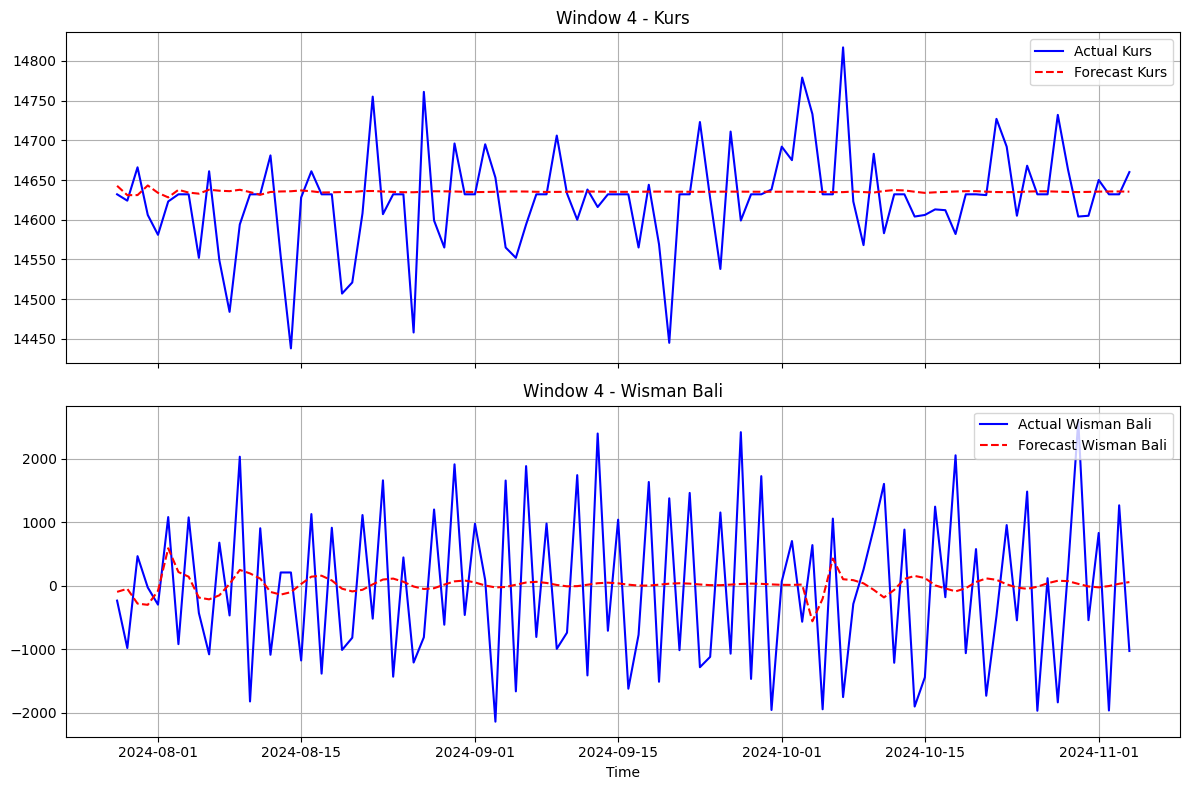

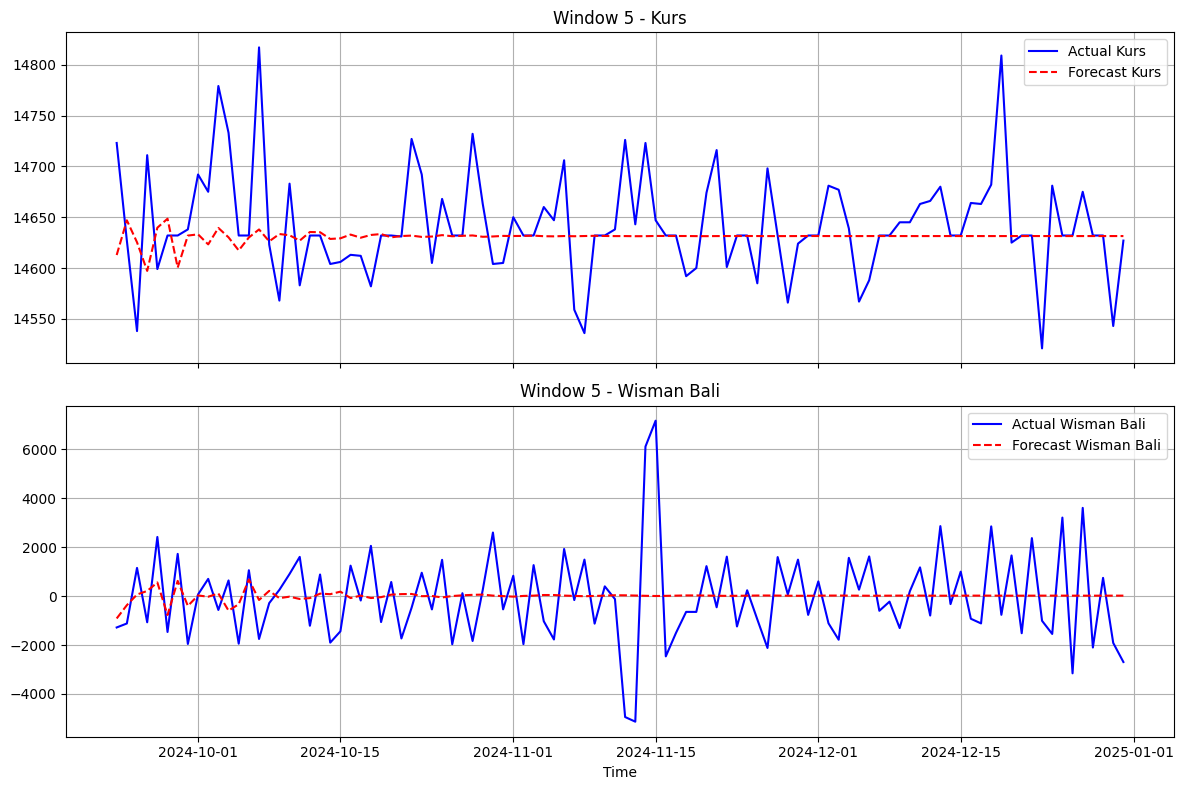

In [22]:
# Loop untuk plot per window
for i in range(5):
    start = i * shift
    end = start + window_size
    if end > n_total:
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(9, 0))
        best_model = model.fit(disp=False)

        # Forecast dengan data normalisasi
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi hasil forecast
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)

        # Denormalisasi test data
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Plot hasil forecast vs data aktual
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

        for j, var in enumerate(endog_vars):
            axes[j].plot(test_denorm.index, test_denorm[var], label=f'Actual {var}', color='blue')
            axes[j].plot(forecast_denorm.index, forecast_denorm[var], label=f'Forecast {var}', color='red', linestyle='dashed')
            axes[j].set_title(f'Window {i+1} - {var}')
            axes[j].legend()
            axes[j].grid()

        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue


Lag 13

In [23]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Parameter untuk sliding window
window_size = 502  # Total data per window
n_test = 100        # Ukuran test per window
n_train = window_size - n_test  # Ukuran train per window
shift = 57          # Geser window sebanyak 57 data tiap iterasi
n_total = len(df_norm_diff)  # Total data

mape_kurs_scores = []
mape_wisman_scores = []

# Loop untuk membuat 5 window
for i in range(5):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break
    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Fit model dengan lag 13
    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(13, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 13 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast dengan data normalisasi
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi hasil forecast
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)

        # Denormalisasi test data
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Hitung MAPE untuk masing-masing variabel
        mape_kurs = mean_absolute_percentage_error(test_denorm['Kurs'], forecast_denorm['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_denorm['Wisman Bali'], forecast_denorm['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE dari semua window
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")



Window 1 | Lag: 13 | AIC: -3138.22
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  402
Model:                            VARX(13)   Log Likelihood                1628.108
                               + intercept   AIC                          -3138.216
Date:                     Fri, 21 Mar 2025   BIC                          -2902.425
Time:                             01:15:20   HQIC                         -3044.858
Sample:                         01-02-2023                                         
                              - 02-07-2024                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.00, 0.24   Jarque-Bera (JB):     234.86, 16259.07
Prob(Q):                        1.00, 0.62   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.87, 0.

Diagnostik Residual

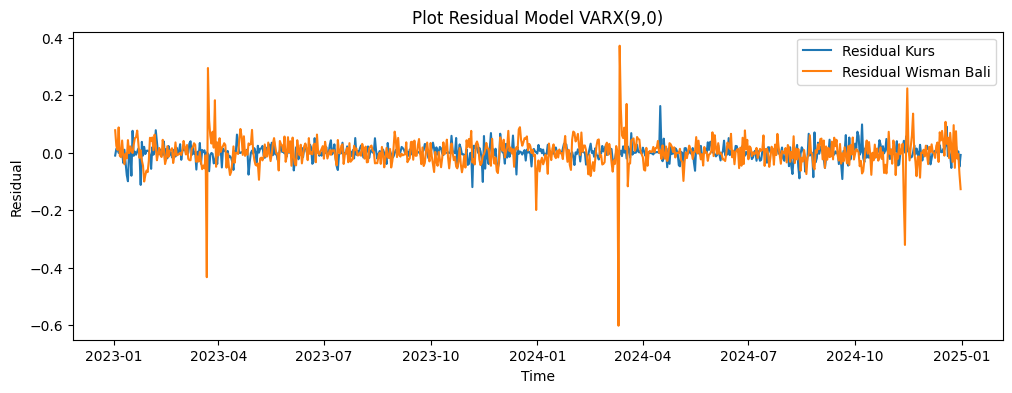


Ljung-Box Test untuk residual Kurs:
     lb_stat  lb_pvalue
10  0.289668        1.0

Ljung-Box Test untuk residual Wisman Bali:
      lb_stat  lb_pvalue
10  11.560726    0.31553


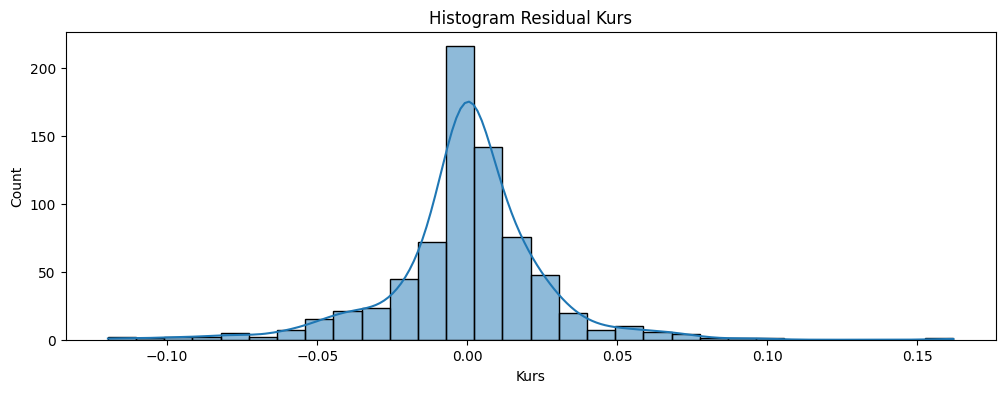

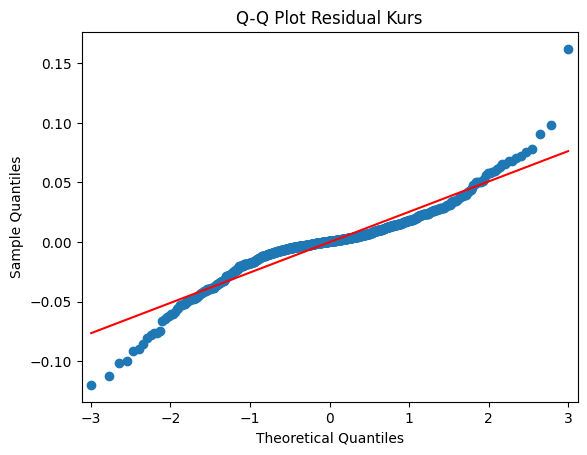

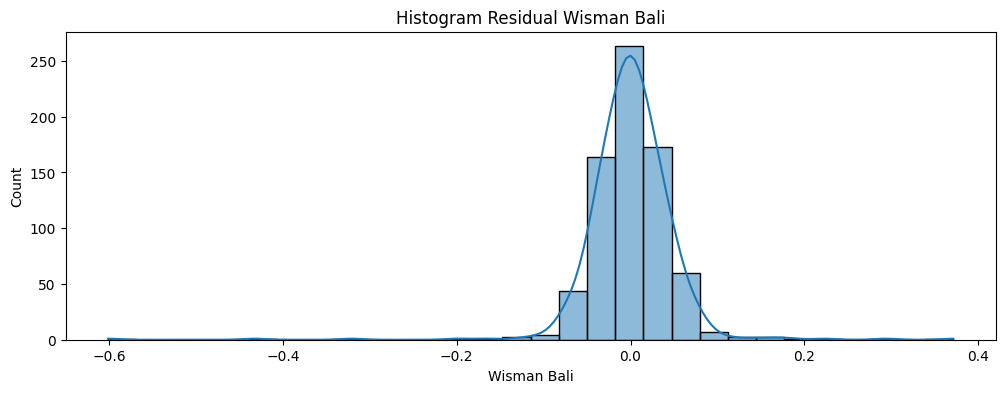

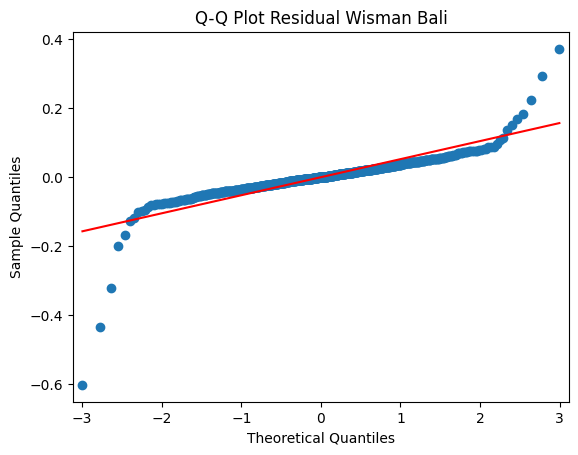


Jarque-Bera Test untuk residual Kurs:
JB Statistic: 798.0888, P-Value: 0.0000

Jarque-Bera Test untuk residual Wisman Bali:
JB Statistic: 40706.1414, P-Value: 0.0000

White Test untuk residual Kurs:
P-Value: 0.669207677462471 (H0: Homoskedastisitas)

White Test untuk residual Wisman Bali:
P-Value: 8.573739348580425e-14 (H0: Homoskedastisitas)


In [24]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_white

# 1️⃣ Fit Model VARX(9,0) di seluruh data
best_model = VARMAX(df_norm_diff[endog_vars], exog=df_norm_diff[exog_vars], order=(9, 0)).fit(disp=False)

# Ambil residual dari model
residuals = best_model.resid

# 2️⃣ Plot Residual untuk masing-masing variabel
plt.figure(figsize=(12, 4))
for var in endog_vars:
    plt.plot(residuals[var], label=f"Residual {var}")
plt.title("Plot Residual Model VARX(9,0)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.show()

# 3️⃣ Uji Autokorelasi Residual (Ljung-Box Test)
for var in endog_vars:
    print(f"\nLjung-Box Test untuk residual {var}:")
    ljung_box_test = sm.stats.acorr_ljungbox(residuals[var], lags=[10], return_df=True)
    print(ljung_box_test)

# 4️⃣ Uji Normalitas Residual (Histogram, Q-Q Plot, dan Jarque-Bera Test)
for var in endog_vars:
    # Plot Histogram
    plt.figure(figsize=(12, 4))
    sns.histplot(residuals[var], kde=True, bins=30)
    plt.title(f"Histogram Residual {var}")
    plt.show()

    # Plot Q-Q
    sm.qqplot(residuals[var], line='s')
    plt.title(f"Q-Q Plot Residual {var}")
    plt.show()

    #Jaque berra
for var in endog_vars:
    # Pastikan residual berbentuk 1D array tanpa NaN
    residual_series = residuals[var].dropna().values

    # Jalankan uji Jarque-Bera
    jb_stat, jb_pvalue = jarque_bera(residual_series)

    print(f"\nJarque-Bera Test untuk residual {var}:")
    print(f"JB Statistic: {jb_stat:.4f}, P-Value: {jb_pvalue:.4f}")

# 4️⃣ Uji Heteroskedastisitas (White Test) per variabel residual
for var in endog_vars:
    print(f"\nWhite Test untuk residual {var}:")
    white_test = het_white(residuals[var], sm.add_constant(df_norm_diff[exog_vars]))
    print(f"P-Value: {white_test[1]} (H0: Homoskedastisitas)")


Uji Ljung-Box ( Autokorelasi jika P-value < 0.05).
Kurs (p = 1.0 ) → tidak ada autokorelasi
Wisman (p = 0.3) → tidak ada autokorelasi.

Uji Jarque-Bera (JB) ( Normal jika P-value > 0.05)
Kurs (p = 0.00) → tidak normal  
Wisman (p = 0.00) → tidak normal

Heteroskedastisitas (Heteroskedastisitas jika P-value < 0.05)
Kurs (p = 0.66) → Tidak ada heteroskedastisitas.
Wisman (p = 8.573739348580425e-14 ) → ada heteroskedastisitas.